# Negative L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(dim*t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 90660.2109375
iteration 0 loss 72808.1015625


iteration 5000 loss 9.19198226928711


iteration 10000 loss 0.18844933807849884


iteration 15000 loss 0.1029401570558548


iteration 20000 loss 0.02093956246972084


iteration 25000 loss 0.01454979833215475


iteration 30000 loss 0.01709301397204399


iteration 35000 loss 0.008602431043982506


iteration 40000 loss 0.007840905338525772


iteration 45000 loss 0.007995953783392906


iteration 50000 loss 0.005177890416234732


iteration 55000 loss 1.3767560720443726


iteration 60000 loss 1.9935194253921509


iteration 65000 loss 0.35031211376190186


iteration 70000 loss 0.004663454368710518


iteration 75000 loss 0.003955915104597807


iteration 80000 loss 0.0035293654073029757


iteration 85000 loss 0.003706004237756133


iteration 90000 loss 0.0037321276031434536


iteration 95000 loss 12.243043899536133


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.03625454753637314


iteration 105000 loss 5.644677730742842e-05


iteration 110000 loss 2.3818929548724554e-06


iteration 115000 loss 0.00024120435409713537


iteration 120000 loss 3.845328319584951e-05


iteration 125000 loss 4.043670742248651e-06


iteration 130000 loss 2.3739535208733287e-06


iteration 135000 loss 4.283933776605409e-06


iteration 140000 loss 0.0020602599252015352


iteration 145000 loss 4.56380917057686e-07


iteration 150000 loss 1.2343684829829726e-05


iteration 155000 loss 3.475915582384914e-05


iteration 160000 loss 1.0124702384928241e-05


iteration 165000 loss 1.585768700351764e-06


iteration 170000 loss 4.759183411806589e-07


iteration 175000 loss 9.52993068494834e-05


iteration 180000 loss 0.014801662415266037


iteration 185000 loss 0.00012990662071388215


iteration 190000 loss 4.1075776380239404e-07


iteration 195000 loss 0.000970149994827807


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 1.496876734563557e-06


iteration 205000 loss 3.180792518264752e-08


iteration 210000 loss 4.427143267093925e-06


iteration 215000 loss 4.956265953204309e-10


iteration 220000 loss 2.1028099261855004e-09


iteration 225000 loss 5.639972933124682e-10


iteration 230000 loss 2.5554081517498162e-08


iteration 235000 loss 1.623489609414719e-08


iteration 240000 loss 5.658832069599384e-09


iteration 245000 loss 7.148715508442649e-10


iteration 250000 loss 1.16023812779531e-08


iteration 255000 loss 3.79256670512973e-09


iteration 260000 loss 2.5447038254355903e-08


iteration 265000 loss 1.6184174000954954e-09


iteration 270000 loss 5.533918323585851e-10


iteration 275000 loss 5.132751446090822e-10


iteration 280000 loss 1.1326861670823973e-09


iteration 285000 loss 4.595843983157266e-10


iteration 290000 loss 5.405628722421341e-10


iteration 295000 loss 2.199434634420072e-09


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 2.8150108022373388e-08


iteration 305000 loss 4.261588770759772e-08


iteration 310000 loss 3.1420493984413156e-10


iteration 315000 loss 3.102701151558307e-10


iteration 320000 loss 3.235298140502607e-10


iteration 325000 loss 8.661299455425819e-10


iteration 330000 loss 5.527399093985252e-10


iteration 335000 loss 2.5669111280990364e-08


iteration 340000 loss 2.488880390671966e-08


iteration 345000 loss 2.33892816225989e-08


iteration 350000 loss 1.0284478824118537e-09


iteration 355000 loss 2.4459674285992605e-09


iteration 360000 loss 5.081877696433423e-10


iteration 365000 loss 1.7217976377992272e-08


iteration 370000 loss 1.5189521862524202e-09


iteration 375000 loss 6.587942968927507e-10


iteration 380000 loss 3.1769739616827053e-10


iteration 385000 loss 3.1184171911391445e-10


iteration 390000 loss 2.642569496558167e-09


iteration 395000 loss 3.662193048814544e-10


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 6.41944319923482e-09


iteration 405000 loss 3.72144842719635e-10


iteration 410000 loss 2.9131769219148396e-10


iteration 415000 loss 2.9325020189929774e-10


iteration 420000 loss 3.3491523443451854e-10


iteration 425000 loss 8.446513488635787e-10


iteration 430000 loss 3.3582325809078384e-10


iteration 435000 loss 2.9961810810164025e-10


iteration 440000 loss 3.2151581397243945e-10


iteration 445000 loss 2.912245722352935e-10


iteration 450000 loss 3.1202798678187094e-10


iteration 455000 loss 3.5797709241336406e-10


iteration 460000 loss 4.5533524173357875e-10


iteration 465000 loss 3.356020739087029e-10


iteration 470000 loss 3.1875677097836785e-10


iteration 475000 loss 3.135413872978887e-10


iteration 480000 loss 4.009110821101558e-10


iteration 485000 loss 3.7782590944779315e-10


iteration 490000 loss 2.9961810810164025e-10


iteration 495000 loss 3.7710415345948434e-10


L2 loss -- Plot

loss 36.1690673828125


loss -117.1182861328125


loss -163.17498779296875


loss -182.2611846923828


loss -187.16851806640625


loss -187.89154052734375


loss -187.94821166992188


loss -187.95028686523438


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.95033264160156


loss -187.95033264160156


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.95033264160156


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


loss -187.9503173828125


final mse:  1.1753773065947826e-08
max, min: 1.6648786 -1.5850879
loss 36.1690673828125


loss -118.48334503173828


loss -164.58303833007812


loss -184.02842712402344


loss -189.23870849609375


loss -190.06097412109375


loss -190.1319122314453


loss -190.1348876953125


loss -190.13491821289062


loss -190.1349334716797


loss -190.13491821289062


loss -190.1349334716797


loss -190.13491821289062


loss -190.1349334716797


loss -190.1349334716797


loss -190.13491821289062


loss -190.1349334716797


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.1349334716797


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.1349334716797


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


loss -190.13491821289062


final mse:  8.481402247184633e-09
max, min: 1.6826655 -1.627575


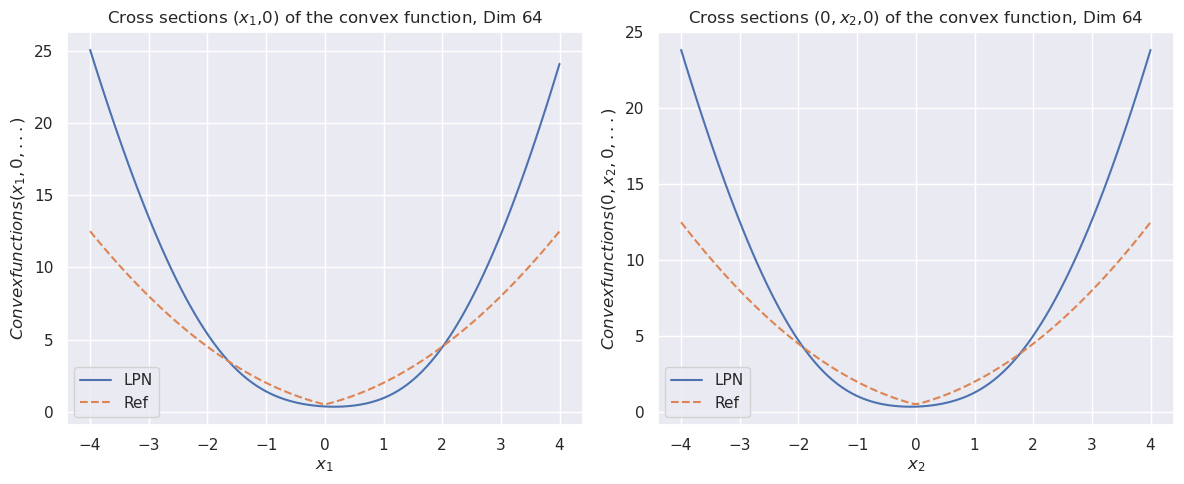

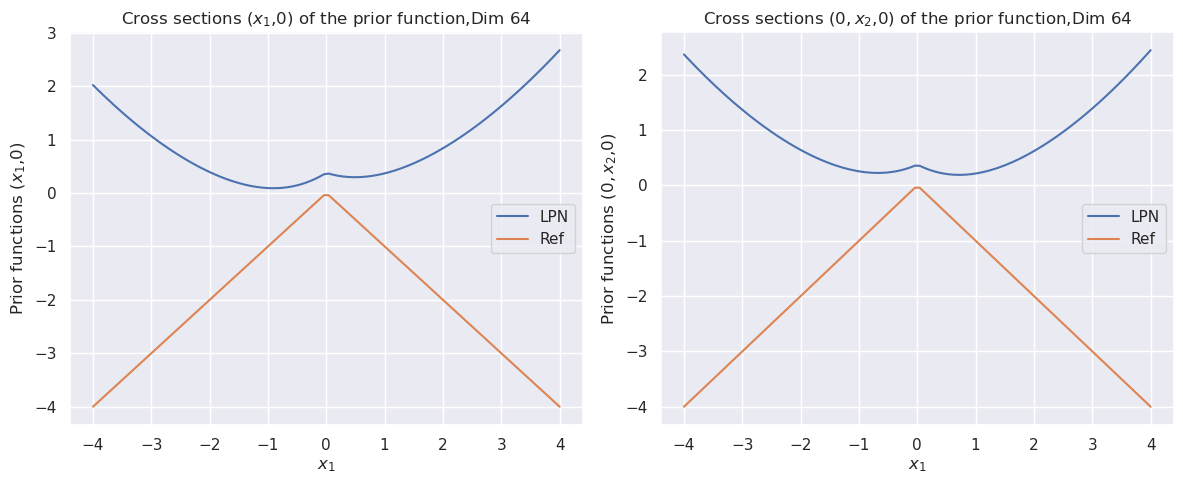

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7581.94873046875
iteration 0 loss 1405.8067626953125


iteration 5000 loss 0.2014106810092926


iteration 10000 loss 0.046023644506931305


iteration 15000 loss 0.013418343849480152


iteration 20000 loss 0.011671975255012512


iteration 25000 loss 0.0028583051171153784


iteration 30000 loss 0.0017877139616757631


iteration 35000 loss 0.001390863093547523


iteration 40000 loss 0.0011120302369818091


iteration 45000 loss 0.1661519706249237


iteration 50000 loss 0.0008265996002592146


iteration 55000 loss 0.0007180679822340608


iteration 60000 loss 0.0007658018148504198


iteration 65000 loss 0.0005945218726992607


iteration 70000 loss 0.000578324485104531


iteration 75000 loss 0.0005145035102032125


iteration 80000 loss 0.013973054476082325


iteration 85000 loss 0.0005593150272034109


iteration 90000 loss 0.01473052054643631


iteration 95000 loss 0.0008586025214754045


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.000387259031413123


iteration 105000 loss 8.009394514374435e-05


iteration 110000 loss 6.836877673777053e-06


iteration 115000 loss 8.550413781449606e-07


iteration 120000 loss 2.8317033866187558e-05


iteration 125000 loss 8.86834428115435e-08


iteration 130000 loss 9.408679034095258e-06


iteration 135000 loss 0.0001803937047952786


iteration 140000 loss 6.945990094209264e-08


iteration 145000 loss 1.7071338334062602e-06


iteration 150000 loss 1.9215782742776355e-07


iteration 155000 loss 5.5245692465177854e-08


iteration 160000 loss 0.00039997167186811566


iteration 165000 loss 5.6902422329585534e-08


iteration 170000 loss 4.9520295419824834e-08


iteration 175000 loss 1.983836909857928e-06


iteration 180000 loss 5.035087013993689e-08


iteration 185000 loss 1.66250356414821e-06


iteration 190000 loss 2.702675203636318e-07


iteration 195000 loss 3.144533138765837e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 7.349979824766706e-08


iteration 205000 loss 2.0329075312019995e-08


iteration 210000 loss 7.24841229384765e-05


iteration 215000 loss 6.620393677714276e-10


iteration 220000 loss 3.9612349511664036e-10


iteration 225000 loss 1.8234130871874754e-10


iteration 230000 loss 1.4718680441117016e-10


iteration 235000 loss 1.4935842045815662e-05


iteration 240000 loss 1.0987277754281877e-10


iteration 245000 loss 5.214308984591298e-09


iteration 250000 loss 6.310001132714405e-11


iteration 255000 loss 8.761708025772919e-11


iteration 260000 loss 5.968031624448145e-11


iteration 265000 loss 1.0232499292328612e-09


iteration 270000 loss 7.018679387682525e-11


iteration 275000 loss 8.722912392400417e-10


iteration 280000 loss 5.3245456654860135e-11


iteration 285000 loss 2.4752573324349214e-09


iteration 290000 loss 5.866750141247934e-11


iteration 295000 loss 6.386748352404936e-10


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 3.3671266663759525e-08


iteration 305000 loss 5.0384550698279185e-11


iteration 310000 loss 4.178145676658751e-11


iteration 315000 loss 3.8120194501001237e-11


iteration 320000 loss 1.0079238554894232e-09


iteration 325000 loss 3.207242110780939e-11


iteration 330000 loss 2.973829169028441e-11


iteration 335000 loss 2.9712100835244115e-11


iteration 340000 loss 2.8187058589979053e-11


iteration 345000 loss 3.523309768937999e-11


iteration 350000 loss 2.9077636132246454e-11


iteration 355000 loss 2.786400624121832e-11


iteration 360000 loss 1.0463728772336367e-09


iteration 365000 loss 2.9175134530490254e-10


iteration 370000 loss 2.9246438604246805e-11


iteration 375000 loss 6.531524377351161e-06


iteration 380000 loss 2.8256908965462735e-11


iteration 385000 loss 2.834131020146291e-11


iteration 390000 loss 2.7896020562967472e-11


iteration 395000 loss 2.875458378348572e-11


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.1350644302818864e-11


iteration 405000 loss 2.901360748874815e-11


iteration 410000 loss 2.7363420557202645e-11


iteration 415000 loss 3.336171963685963e-11


iteration 420000 loss 2.6778433637186794e-11


iteration 425000 loss 3.420573199686139e-11


iteration 430000 loss 2.745073265919551e-11


iteration 435000 loss 2.4837208678629707e-11


iteration 440000 loss 2.6929774382677962e-11


iteration 445000 loss 3.0640510961799095e-11


iteration 450000 loss 2.916785910023201e-11


iteration 455000 loss 2.7252826731438695e-11


iteration 460000 loss 2.600136078667603e-11


iteration 465000 loss 2.871965859574388e-11


iteration 470000 loss 2.5483313376151173e-11


iteration 475000 loss 2.935703416473423e-11


iteration 480000 loss 2.7014173883954662e-11


iteration 485000 loss 2.7372151420457236e-11


iteration 490000 loss 2.7270288457947878e-11


iteration 495000 loss 2.90398018132354e-11


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


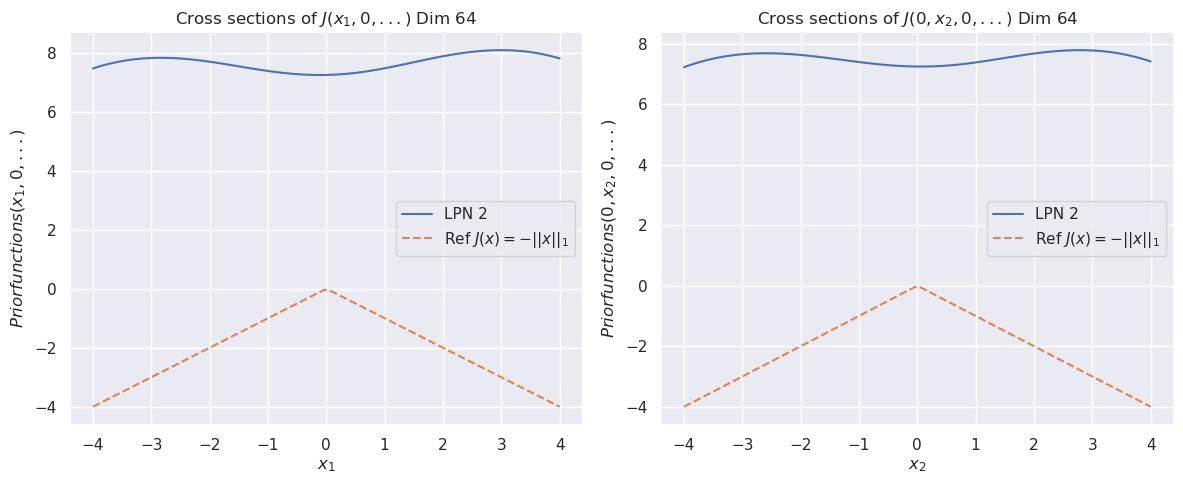

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)